In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

Dataset is from [Kaggle](https://www.kaggle.com/datasets/devzohaib/mushroom-edibility-classification).

In [2]:
df = pd.read_csv('data/raw/secondary_data.csv', sep=';', header=0)

In [3]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [5]:
df['class'].value_counts()

p    33888
e    27181
Name: class, dtype: int64

About 44.5% of the samples are considered edible.

In [6]:
missing_data = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing_data.columns = ['count', '%']
missing_data[missing_data['%'] > 0].sort_values(by='%', ascending=False)

,count,%
veil-type,57892,94.797688
spore-print-color,54715,89.595376
veil-color,53656,87.861272
stem-root,51538,84.393064
stem-surface,38124,62.427746
gill-spacing,25063,41.040462
cap-surface,14120,23.121387
gill-attachment,9884,16.184971
ring-type,2471,4.046243


There are five columns that have a significant amount of missingness. Two of these, the `veil-color` and `stem-surface` are a bit curious because there is a category for 'none' for both of these (encoded as f), which may indicate that there is information simply not recorded rather than that the the nan data points represent something in particular. There are a lot of other features that may have promise, so at the time, the excessively missing columns will be dropped.

In [7]:
df = df[df.columns[df.isnull().mean() < .5]]
missing_data = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing_data.columns = ['count', '%']
missing_data.sort_values(by='%', ascending=False)

,count,%
gill-spacing,25063,41.040462
cap-surface,14120,23.121387
gill-attachment,9884,16.184971
ring-type,2471,4.046243
class,0,0.000000
cap-diameter,0,0.000000
cap-shape,0,0.000000
cap-color,0,0.000000
does-bruise-or-bleed,0,0.000000
gill-color,0,0.000000


In [8]:
class_palette = sns.color_palette(['#fc8d62', '#8da0cb'])
sns.set_palette(class_palette)

In [9]:
# Convert cm to mm
df['stem-height'] = df['stem-height'] * 10
df['cap-diameter'] = df['cap-diameter'] * 10

## Numeric

In [10]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,67.338545,65.815383,12.149410
std,52.648449,33.700169,10.035955
min,3.800000,0.000000,0.000000
25%,34.800000,46.400000,5.210000
50%,58.600000,59.500000,10.190000
75%,85.400000,77.400000,16.570000
max,623.400000,339.200000,103.910000


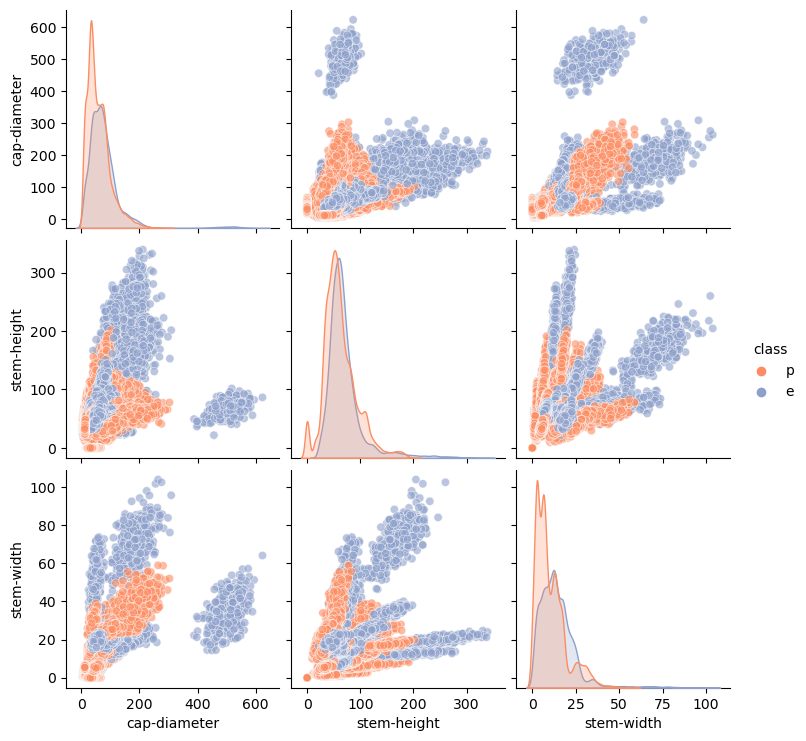

In [11]:
_ = sns.pairplot(df, hue='class', plot_kws={'alpha': 0.6})
plt.show()

Smaller-sized mushrooms overall tend to be poisonous, especially smaller cap diameters. However, there is a lot of overlap, so measuring the mushrooms alone would probably not be safe.

The height, width, and diameters are positively correlated with one another, which is unsurprising.

## Categoric

In [12]:
cat_cols = df.select_dtypes(include='object').columns[1:18]
cat_cols

Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color',
       'has-ring', 'ring-type', 'habitat', 'season'],
      dtype='object')

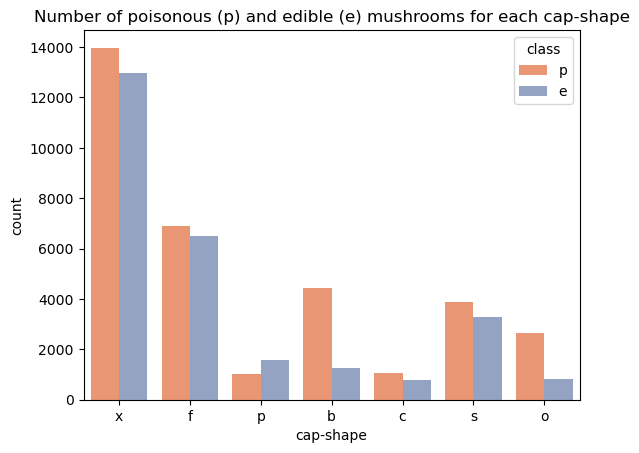

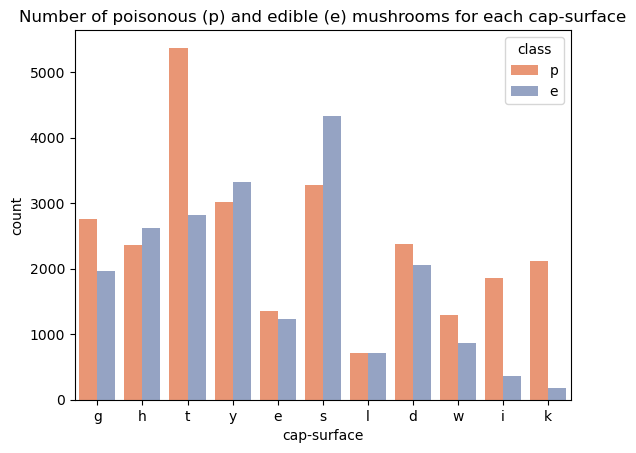

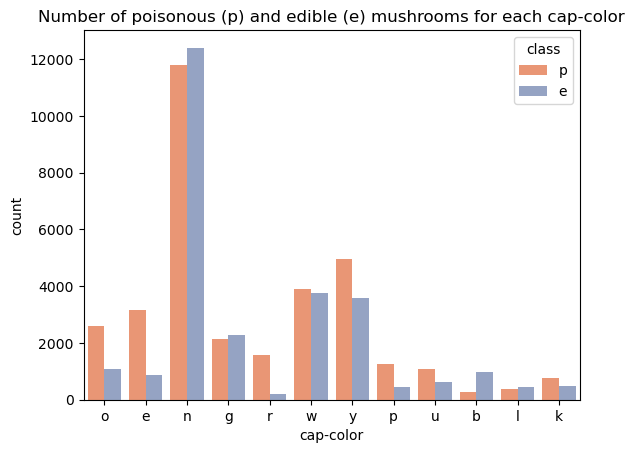

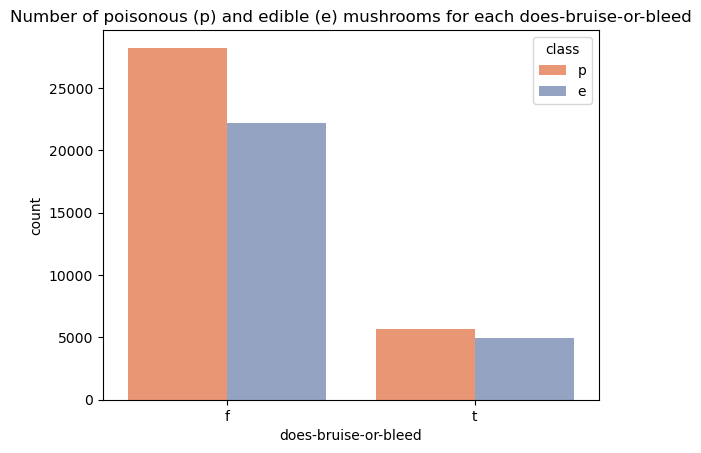

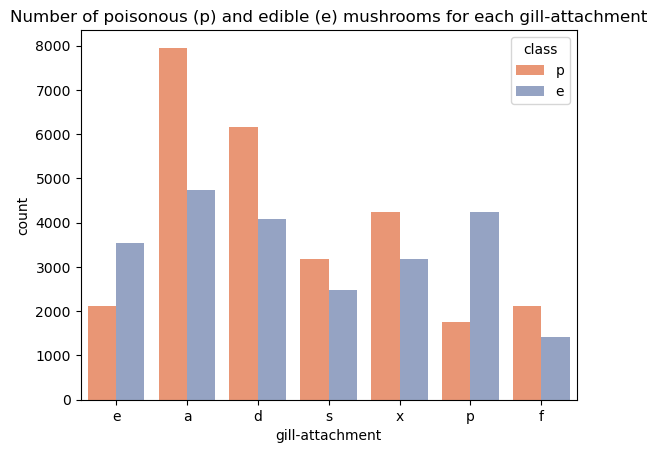

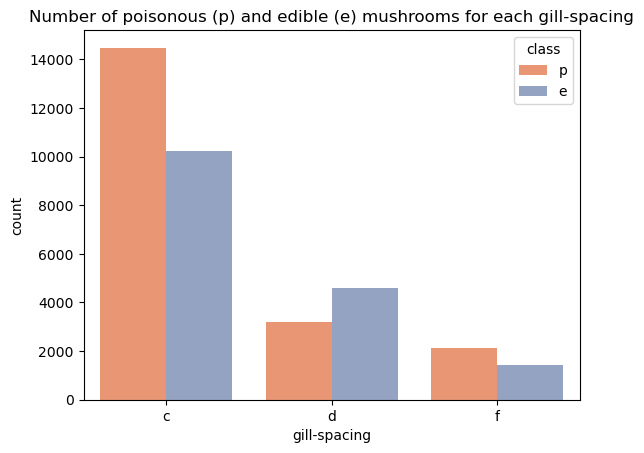

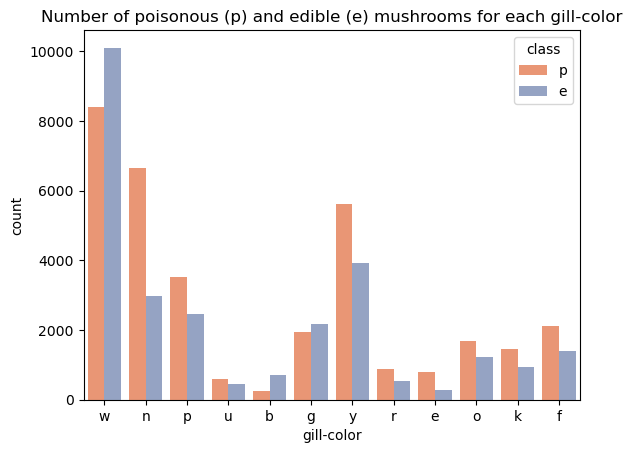

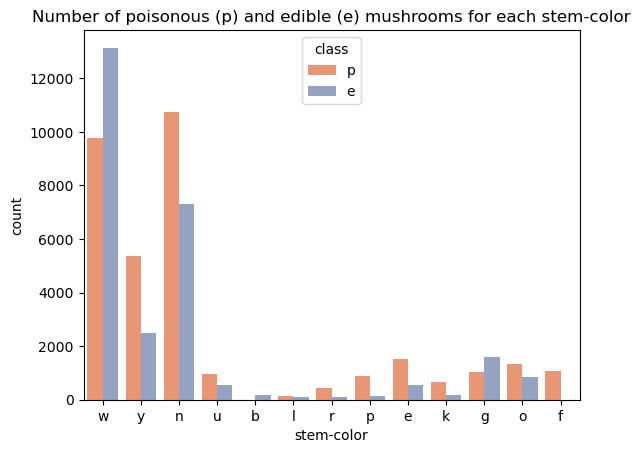

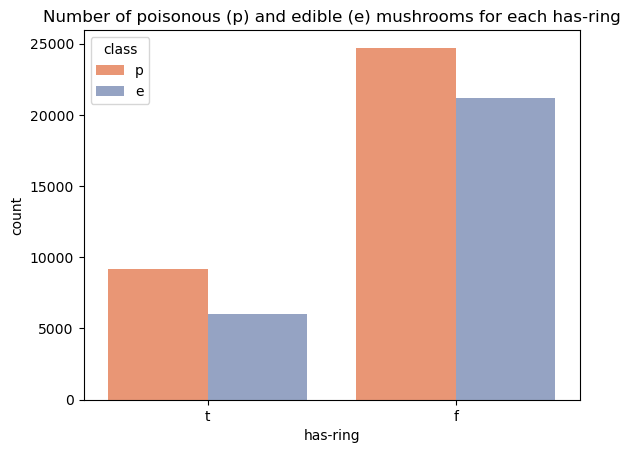

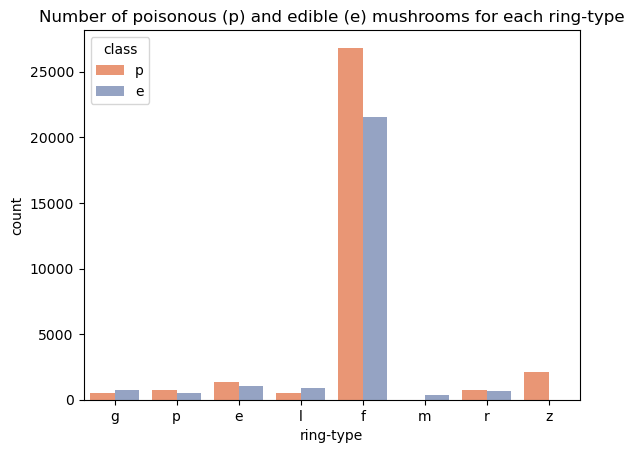

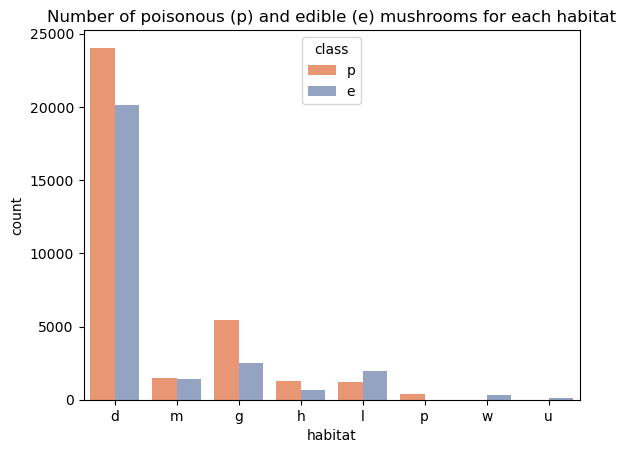

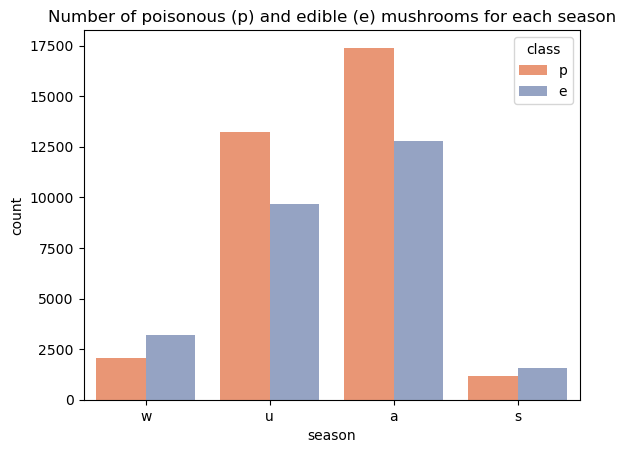

In [13]:
for c in cat_cols:
    g = sns.countplot(data=df, x=c, hue='class')
    g.set_title('Number of poisonous (p) and edible (e) mushrooms for each {}'.format(c))
    plt.show()

In [14]:
def stacked_barh_100(x_var, y_var, df):
    # Please note that you will need to invert the x and y coordinates in the text function
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    df_grouped.plot.barh(stacked=True, color=['#8da0cb','#fc8d62'])
    plt.legend(
        bbox_to_anchor=(0.5, 1.02),
        loc="lower center",
        borderaxespad=0,
        frameon=False,
        ncol=3,
    )
    plt.title('Proportion of edible (e) and poisonous (p) mushrooms for {}'.format(x_var), pad=30)
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        #print(ix, row)
        cumulative = 0
        for element in row:
            if np.isnan(element):
                element = 0
            if element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
    plt.tight_layout()
    plt.show()

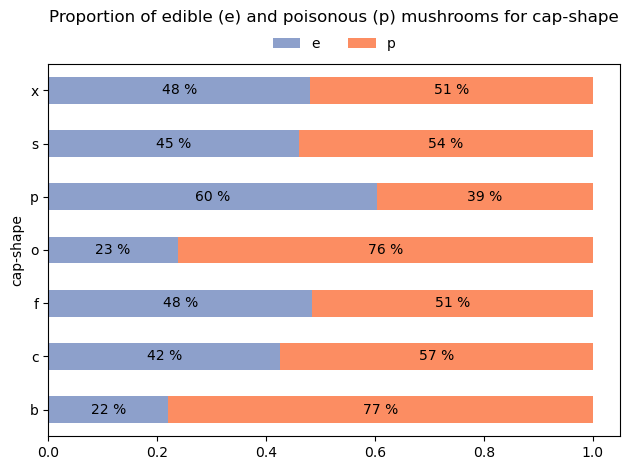

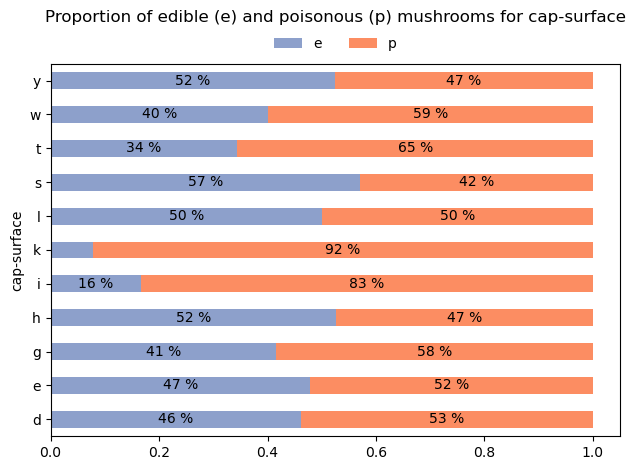

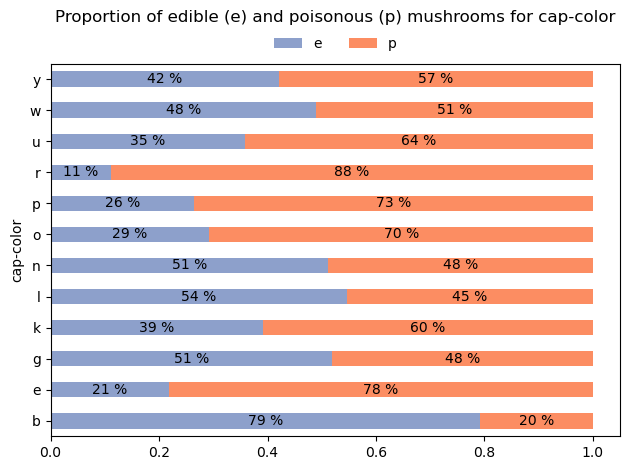

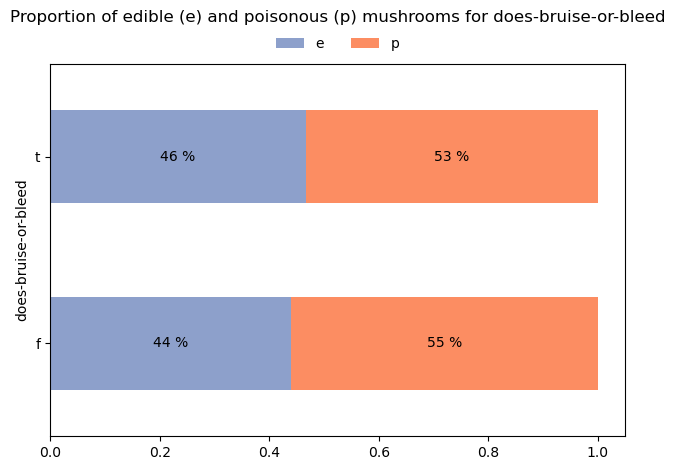

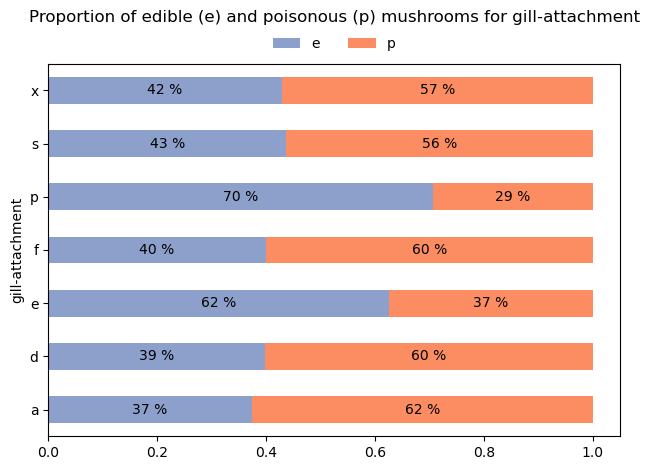

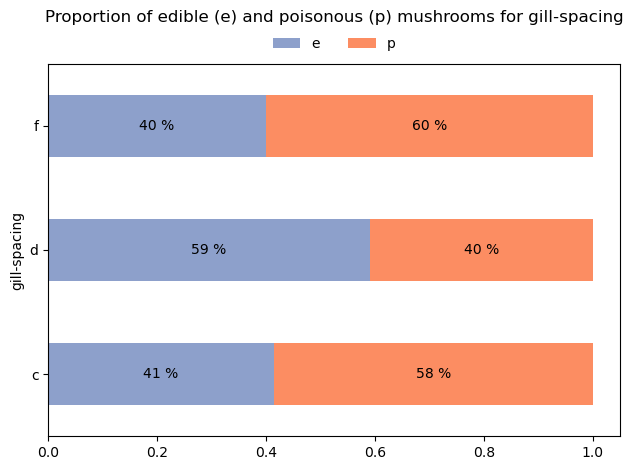

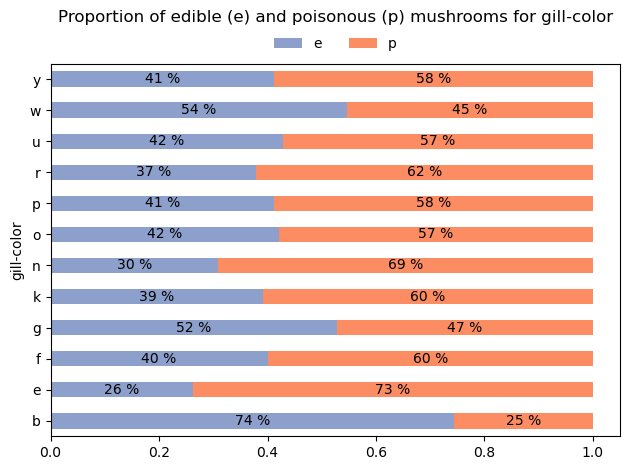

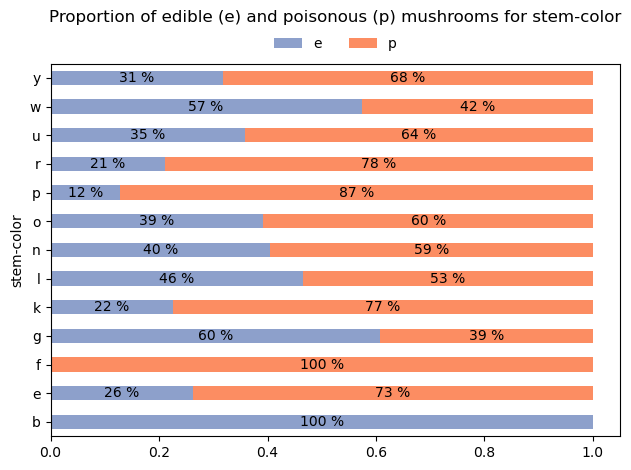

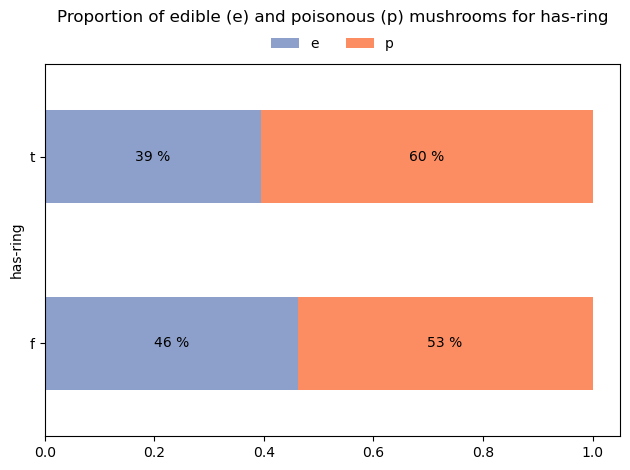

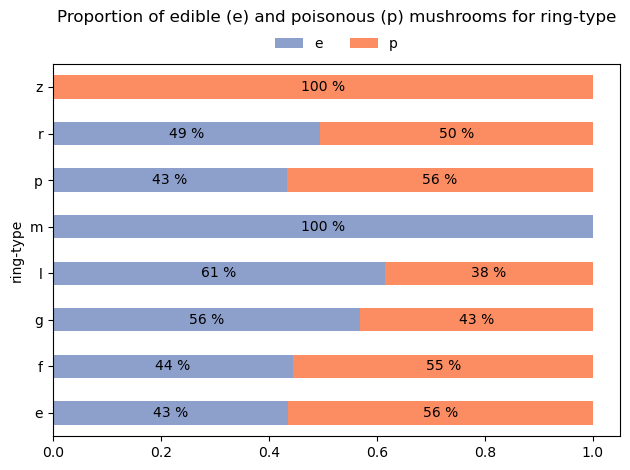

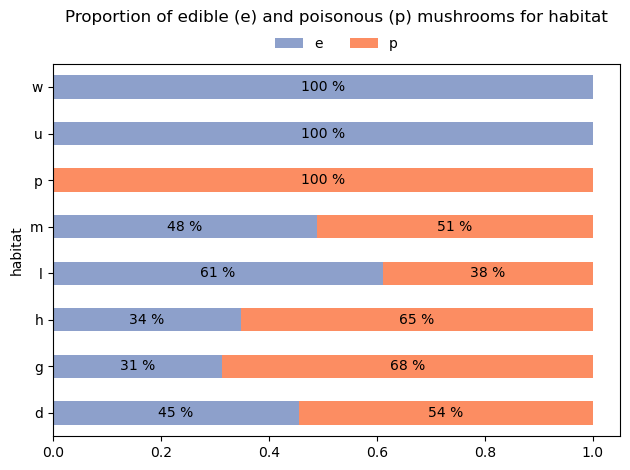

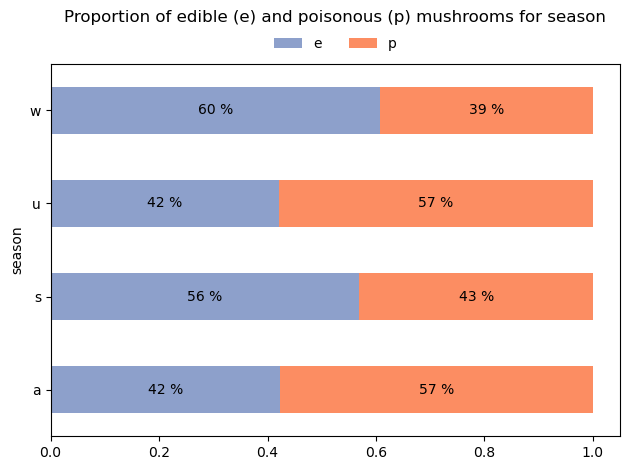

In [15]:
for c in cat_cols:
    stacked_barh_100(c, 'class', df)

cap shape
 - p = spherical = likely edible
 - b, o = bell, other = very likely poisonous

cap surface
 - w, t = wrinkled, sticky = likely poisonous
 - k, i = silky, fibrous = very likely poisonous

cap color
 - b = buff = very likely edible
 - u, k = purple, black = likely poisonous
 - r, p, o, e = green, pink, orange, red = very likely poisonous

bruise/bleed inconclusive

gill attachment
 - p = pores = very likely edible
 - e = free = likely edible
 - f, d, a = none, decurrent, adnate = likely poisonous

gill spacing
 - f, c = none, close = likely poisonous

gill color
 - b = buff = very likely edible
 - y, r, p, n, k, f = yellow, green, pink, brown, black, none = likely poisonous
 - e = red = very likely poisonous

stem color
 - b = buff = definitely edible
 - g = gray = likely edible
 - y, u, o, n = yellow, purple, orange, brown = likely poisonous
 - r, p, k, e = green, pink, black, red = very likely poisonous
 - f = none = definitely poisonous

has ring
 - t = ring = likely poisonous

ring type
 - m = movable = definitely edible
 - l = large = likely edible
 - z = zone = definitely poisonous

habitat
 - w, u = waste, urban = definitely edible
 - l = leaves = likely edible
 - h, g = heaths, grasses = likely poisonous
 - p = paths = definitely poisonous

season
 - w = likely edible

Some patterns do seem to appear within each feature. For the average person (that is, a non-mushroom-expert like myself), a few features make some intuitive sense. The more vibrant cap, gill, and stem  colors, which we would often associate in natural things (perhaps aside from flowers) to be common warning colors, are more likely to be poisonous. In particular, red is very likely poisonous across the board, and conversely, buff, a light brown-yellow, is very often edible.

Something that I find interesting is how the habitat tends to relate to the mushrooms' edibility. The mushrooms in the three more open habitats with less cover potential tend to be poisonous.

In [16]:
full_df = df.fillna(value="unknown")
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           61069 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       61069 non-null  object 
 7   gill-spacing          61069 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

In [17]:
for col in full_df.select_dtypes(include='object').columns:
    full_df[col] = full_df[col].astype('category')

In [18]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   class                 61069 non-null  category
 1   cap-diameter          61069 non-null  float64 
 2   cap-shape             61069 non-null  category
 3   cap-surface           61069 non-null  category
 4   cap-color             61069 non-null  category
 5   does-bruise-or-bleed  61069 non-null  category
 6   gill-attachment       61069 non-null  category
 7   gill-spacing          61069 non-null  category
 8   gill-color            61069 non-null  category
 9   stem-height           61069 non-null  float64 
 10  stem-width            61069 non-null  float64 
 11  stem-color            61069 non-null  category
 12  has-ring              61069 non-null  category
 13  ring-type             61069 non-null  category
 14  habitat               61069 non-null  category
 15  se

## Preprocessing and Modeling

In [19]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns='class'), full_df['class'], test_size=0.3)

In [20]:
# Encode categories
oh_encoder = OneHotEncoder(use_cat_names=True).fit(X_train)
X_train_oh = oh_encoder.transform(X_train)
X_test_oh = oh_encoder.transform(X_test)
print(X_train_oh.columns)

Index(['cap-diameter', 'cap-shape_x', 'cap-shape_f', 'cap-shape_b',
       'cap-shape_s', 'cap-shape_p', 'cap-shape_o', 'cap-shape_c',
       'cap-surface_unknown', 'cap-surface_l', 'cap-surface_h',
       'cap-surface_y', 'cap-surface_i', 'cap-surface_t', 'cap-surface_s',
       'cap-surface_g', 'cap-surface_e', 'cap-surface_w', 'cap-surface_k',
       'cap-surface_d', 'cap-color_p', 'cap-color_n', 'cap-color_y',
       'cap-color_w', 'cap-color_e', 'cap-color_r', 'cap-color_k',
       'cap-color_g', 'cap-color_o', 'cap-color_u', 'cap-color_l',
       'cap-color_b', 'does-bruise-or-bleed_f', 'does-bruise-or-bleed_t',
       'gill-attachment_unknown', 'gill-attachment_x', 'gill-attachment_a',
       'gill-attachment_e', 'gill-attachment_d', 'gill-attachment_s',
       'gill-attachment_p', 'gill-attachment_f', 'gill-spacing_c',
       'gill-spacing_d', 'gill-spacing_unknown', 'gill-spacing_f',
       'gill-color_g', 'gill-color_n', 'gill-color_k', 'gill-color_y',
       'gill-color_e', 

In [21]:
# Scale features
s_scaler = StandardScaler().fit(X_train_oh)
X_train_ohsc = s_scaler.transform(X_train_oh)
X_test_ohsc = s_scaler.transform(X_test_oh)

### Logistic Regression

In [22]:
lr_model = LogisticRegression()
lr_model.fit(X_train_ohsc, y_train)
lr_model.score(X_train_ohsc, y_train)

0.7826097127350987

In [23]:
lr_model.score(X_test_ohsc, y_test)

0.7790513618252278

### K Nearest Neighbors

In [24]:
knn_param_grid = {'n_neighbors':[1,2,4,6]}
knn = KNeighborsClassifier()
knn_grid_cv = GridSearchCV(knn, param_grid=knn_param_grid, cv=5, n_jobs=-1)
knn_grid_cv.fit(X_train_ohsc, y_train)

C:\Users\chian\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.99995322        nan 0.99981286 0.99978947]
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 4, 6]})

In [25]:
print("Best Score:", str(knn_grid_cv.best_score_))
print("Best Parameters:" + str(knn_grid_cv.best_params_))

Best Score: 0.9999532163742689
Best Parameters:{'n_neighbors': 1}


In [26]:
print("Test Score:", knn_grid_cv.best_estimator_.score(X_test_ohsc, y_test))

C:\Users\chian\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test Score: 0.9999454178265379


### Random Forest

In [27]:
rf_params = {'n_estimators': [10, 30, 60, 70, 80],
             'max_features': [0.2,0.5,1.0],
             'criterion': ['gini', 'entropy']}
rf_grid_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=rf_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train_ohsc, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [0.2, 0.5, 1.0],
                         'n_estimators': [10, 30, 60, 70, 80]})

In [28]:
print("Best Score:", str(rf_grid_cv.best_score_))
print("Best Parameters:", str(rf_grid_cv.best_params_))

Best Score: 0.9999766081871344
Best Parameters: {'criterion': 'gini', 'max_features': 0.2, 'n_estimators': 60}


In [29]:
print("Test Score:", rf_grid_cv.best_estimator_.score(X_test_ohsc, y_test))

Test Score: 1.0


### Histogram-based Gradient Boosting

Scikit learn has a [HistGradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html), which is meant to be faster for big datasets (n_samples >= 10000), and this dataset has 61069 samples.

In [30]:
gb_params = {'max_iter': [10,20,30,40],
             'learning_rate': [0.1,0.3,0.5,0.7,0.9,1.0]}
gb_grid_cv = GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=42), param_grid=gb_params, cv=5, n_jobs=-1)
gb_grid_cv.fit(X_train_ohsc, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                         'max_iter': [10, 20, 30, 40]})

In [31]:
print("Best Score:", str(gb_grid_cv.best_score_))
print("Best Parameters:", str(gb_grid_cv.best_params_))

Best Score: 0.9999298190889944
Best Parameters: {'learning_rate': 0.7, 'max_iter': 40}


In [32]:
gb_grid_cv.best_estimator_.score(X_test_ohsc, y_test)

0.9998908356530757

### Comparisons

The KNN and random forest models performed rather well, but they also took a somewhat long time to process. The histogram-based gradient boosting on the other hand was much faster, and it produced comparable results.

Running through the fitting and testing of models multiple times (by nature of restarting the notebok) demonstrates that the models have some randomness affecting the result; the results occasionally come out with 1-2 different label classifications.

In [33]:
start_time = time.time()
y_pred_knn = knn_grid_cv.best_estimator_.predict(X_test_ohsc)
end_time = time.time()
pl_knn = confusion_matrix(y_test, y_pred_knn)
print(pl_knn)
print((end_time - start_time) * 1000)

C:\Users\chian\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[ 8157     1]
 [    0 10163]]
8437.627077102661


C:\Users\chian\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


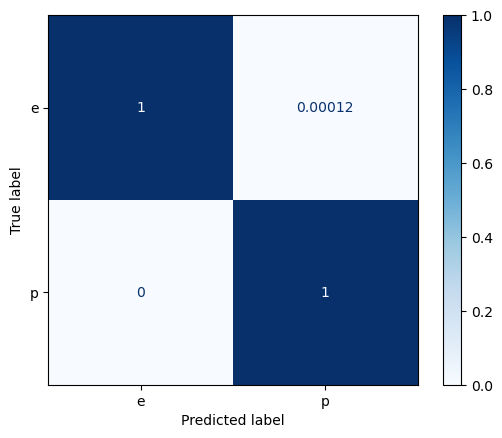

In [34]:
disp = ConfusionMatrixDisplay.from_estimator(
    knn_grid_cv.best_estimator_, X_test_ohsc, y_test,
    display_labels=knn_grid_cv.best_estimator_.classes_,
    cmap=plt.cm.Blues,
    normalize='true')
plt.show()

In [35]:
start_time = time.time()
y_pred_rf = rf_grid_cv.best_estimator_.predict(X_test_ohsc)
end_time = time.time()
pl_rf = confusion_matrix(y_test, y_pred_rf)
print(pl_rf)
print((end_time - start_time) * 1000)

[[ 8158     0]
 [    0 10163]]
130.6772232055664


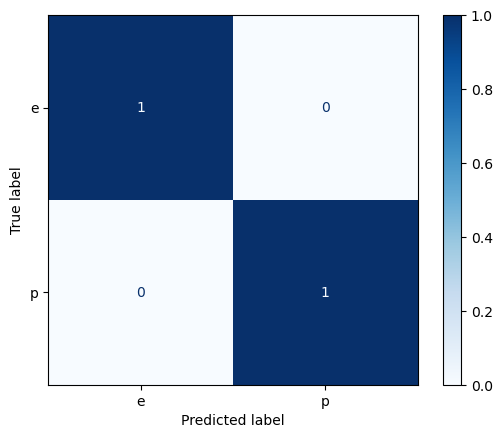

In [36]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_grid_cv.best_estimator_, X_test_ohsc, y_test,
    display_labels=rf_grid_cv.best_estimator_.classes_,
    cmap=plt.cm.Blues,
    normalize='true')
plt.show()

In [37]:
start_time = time.time()
y_pred_gb = gb_grid_cv.best_estimator_.predict(X_test_ohsc)
end_time = time.time()
pl_gb = confusion_matrix(y_test, y_pred_gb)
print(pl_gb)
print((end_time - start_time) * 1000)

[[ 8158     0]
 [    2 10161]]
21.938323974609375


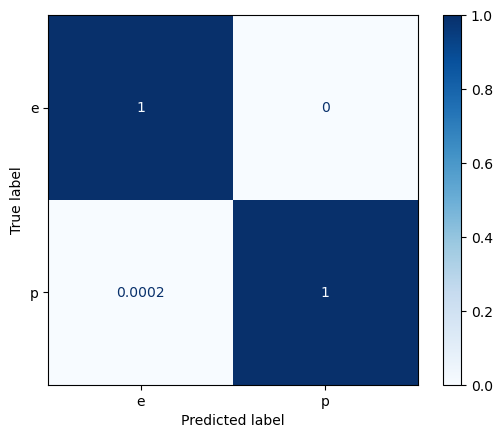

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(
    gb_grid_cv.best_estimator_, X_test_ohsc, y_test,
    display_labels=gb_grid_cv.best_estimator_.classes_,
    cmap=plt.cm.Blues,
    normalize='true')
plt.show()

For these three models, the performance is comparable and good across the board, but the computation speed differs vastly, with gradient boosting being the fastest by far. The random forest model is still significantly faster than KNN. For this particular application, we would probably approach it as "better safe than sorry". That is, if we consider poisonous as positive, then we would likely prioritize correctly labeling poisonous mushrooms, and we would want to maximize true positives and minimize false negatives. In other words, we would assume more things are incorrectly poisonous and worry less about labeling things edible. We want to more greedily label things as poisonous than not.

In [39]:
pd.Series(rf_grid_cv.best_estimator_.feature_importances_, index=s_scaler.feature_names_in_).sort_values(ascending=False)[:20]

stem-width                 0.097118
stem-height                0.071449
cap-diameter               0.056837
stem-color_w               0.040072
gill-spacing_d             0.031649
gill-spacing_c             0.026477
gill-color_w               0.025847
gill-attachment_p          0.021569
does-bruise-or-bleed_f     0.021165
cap-surface_unknown        0.019666
gill-color_y               0.018415
gill-attachment_x          0.018405
does-bruise-or-bleed_t     0.018076
gill-spacing_unknown       0.017013
gill-attachment_d          0.016408
cap-surface_s              0.015592
cap-surface_g              0.015270
cap-shape_b                0.015242
ring-type_z                0.015209
gill-attachment_unknown    0.014850
dtype: float64

In terms of interpretability, the random forest model is very accessible, and it shows that the three numeric features were actually ranked as the most important: the `stem-width`, `stem-height`, and `cap-diameter`. When recalling the pairplots for these features, this is not too unsurprising, since there were clear regions that could be clusters of edible and poisonous mushrooms. As for the categorical features, a white `stem-color`, distant or closed `gill-spacing`, and white `gill-color` were somewhat important. From a common perspective, it may be surprising that cap color was not one of the more important features, but at least the stem and gill colors were considered more important.

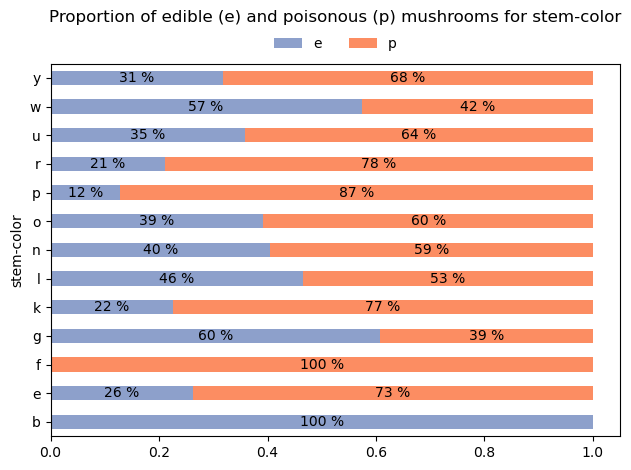

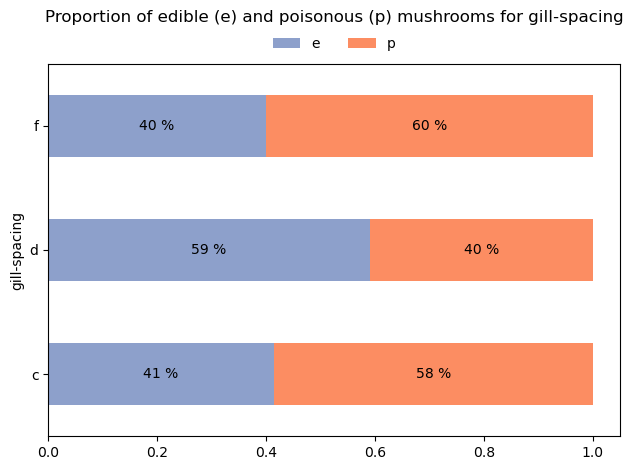

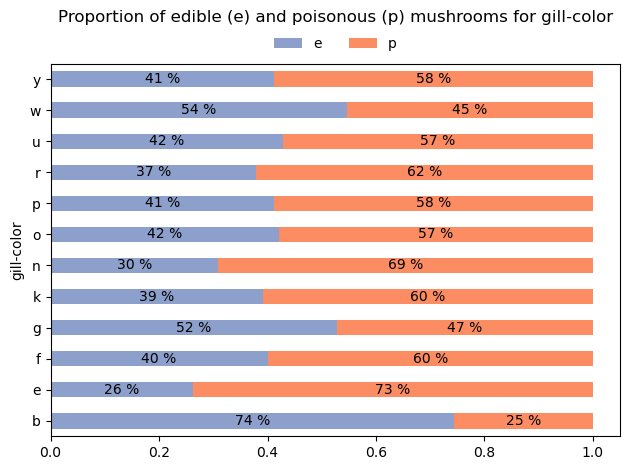

In [40]:
stacked_barh_100('stem-color', 'class', df)
stacked_barh_100('gill-spacing', 'class', df)
stacked_barh_100('gill-color', 'class', df)

Let's reexamine the numerical features again.

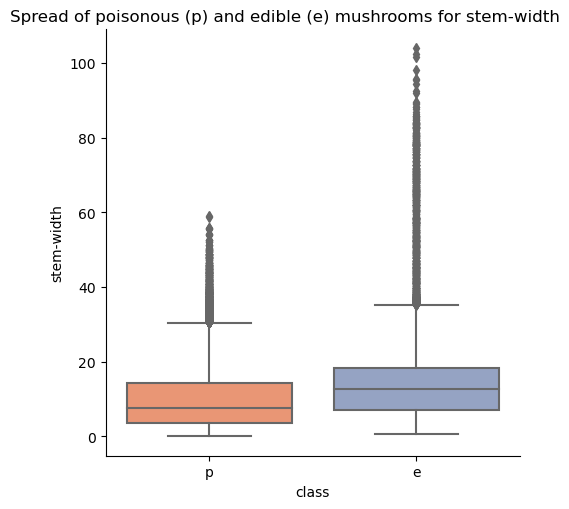

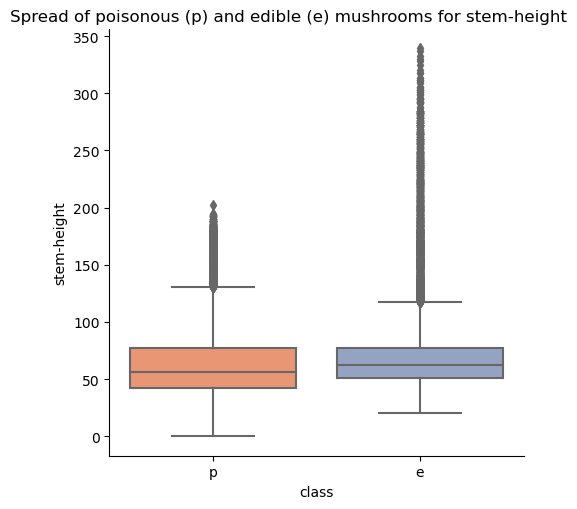

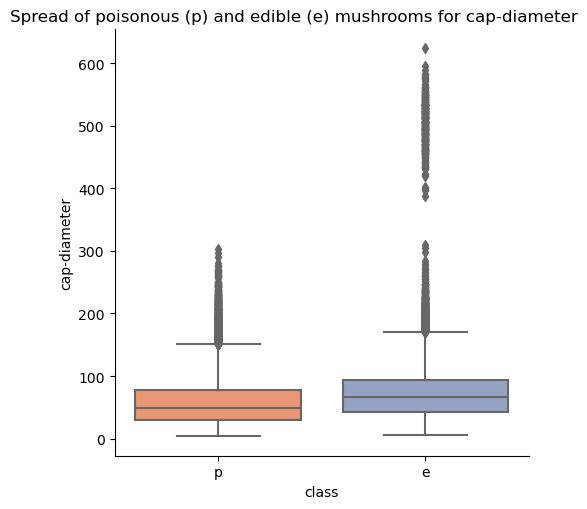

In [41]:
for num_col in ['stem-width','stem-height','cap-diameter']:
    g = sns.catplot(kind='box', data=df, x='class', y=num_col)
    g.fig.suptitle('Spread of poisonous (p) and edible (e) mushrooms for {}'.format(num_col), y=1.01)
    plt.show()

As we said before, we can clearly see that there is indeed a pattern with poisonous mushrooms being smaller in general, and the difference between the two classes is greatest in stem width. If someone was foraging for mushrooms, they might be carrying around a ruler with millimeter-accuracy, but is that realistic? The difference between the classes overall is not that big either, especially to the naked eye--not to mention that humans are not that great at estimating sizes, and a mushroom could be a different size at different points in its development. So, this begs the question, can we find good visual features that humans can approximate that can predict edibility well enough?

### A Purely Categorical Model

In [42]:
full_cat_df = full_df.drop(columns=['stem-width','stem-height','cap-diameter'])
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    full_cat_df.drop(columns='class'), full_cat_df['class'], test_size=0.3)

In [43]:
# Encode categories
cat_oh_encoder = OneHotEncoder(use_cat_names=True).fit(X_train_cat)
X_train_catoh = cat_oh_encoder.transform(X_train_cat)
X_test_catoh = cat_oh_encoder.transform(X_test_cat)
# Scale features
cat_s_scaler = StandardScaler().fit(X_train_catoh)
X_train_catohsc = cat_s_scaler.transform(X_train_catoh)
X_test_catohsc = cat_s_scaler.transform(X_test_catoh)

In [44]:
cat_rf_params = {'n_estimators': [10, 30, 60, 70, 80],
             'max_features': [0.2,0.5,1.0],
             'criterion': ['gini', 'entropy']}
cat_rf_grid_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=cat_rf_params, cv=5, n_jobs=-1)
cat_rf_grid_cv.fit(X_train_catohsc, y_train_cat)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [0.2, 0.5, 1.0],
                         'n_estimators': [10, 30, 60, 70, 80]})

In [45]:
print("Best Score:", str(cat_rf_grid_cv.best_score_))
print("Best Parameters:", str(cat_rf_grid_cv.best_params_))

Best Score: 0.9965378393150186
Best Parameters: {'criterion': 'gini', 'max_features': 0.2, 'n_estimators': 10}


In [46]:
print("Test Score:", cat_rf_grid_cv.best_estimator_.score(X_test_catohsc, y_test_cat))

Test Score: 0.996288412204574


A model looking at only categories still almost reaches 100%, but it is slightly worse than if we were to keep the numerical features in our judgment. There is a bit of overlap with the highest categorical important features, with white `stem-color`, pore `gill-attachment`, white `gill-color`, and distant `gill-spacing` reappear. The new features were is a smooth `cap-surface`.

In [47]:
pd.Series(cat_rf_grid_cv.best_estimator_.feature_importances_, index=cat_s_scaler.feature_names_in_).sort_values(ascending=False)[:20]

stem-color_w              0.041744
gill-attachment_p         0.030955
gill-color_w              0.030158
cap-surface_s             0.029580
gill-spacing_d            0.028995
gill-spacing_c            0.026960
gill-attachment_x         0.025568
cap-surface_unknown       0.024037
cap-shape_b               0.023641
does-bruise-or-bleed_t    0.022668
cap-surface_g             0.022589
cap-shape_x               0.021111
does-bruise-or-bleed_f    0.020358
gill-attachment_a         0.018287
gill-color_y              0.017950
gill-spacing_unknown      0.017641
cap-surface_d             0.017243
gill-attachment_s         0.017226
cap-color_n               0.016972
ring-type_z               0.016571
dtype: float64

- stem-color_w              0.041744 57% edible
- gill-attachment_p         0.030955 70% edible
- gill-color_w              0.030158 54% edible
- cap-surface_s             0.029580 57% edible
- gill-spacing_d            0.028995 59% edible

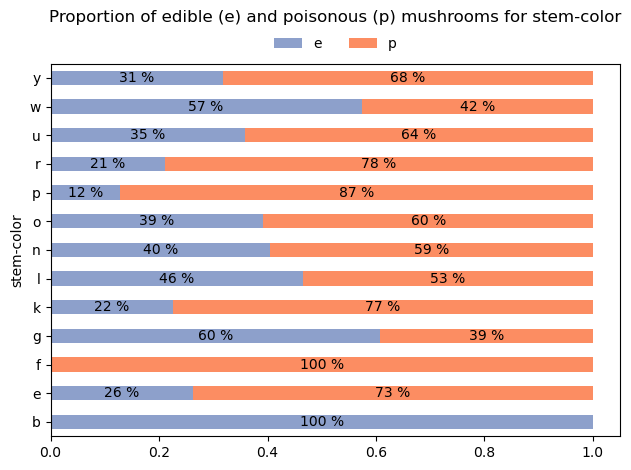

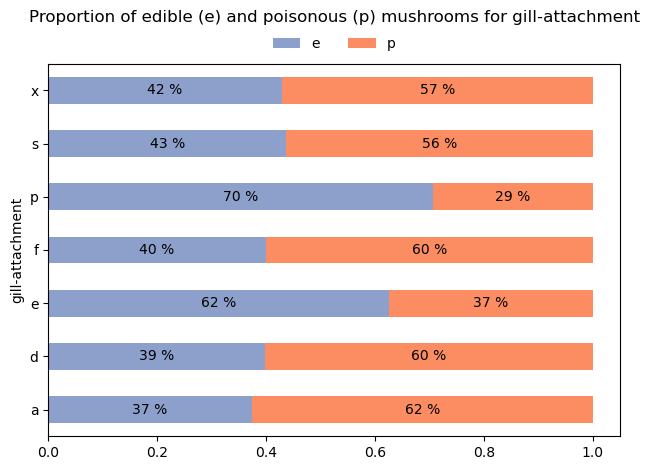

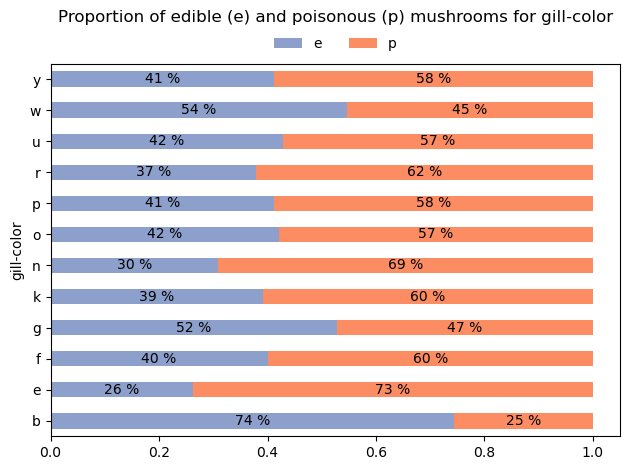

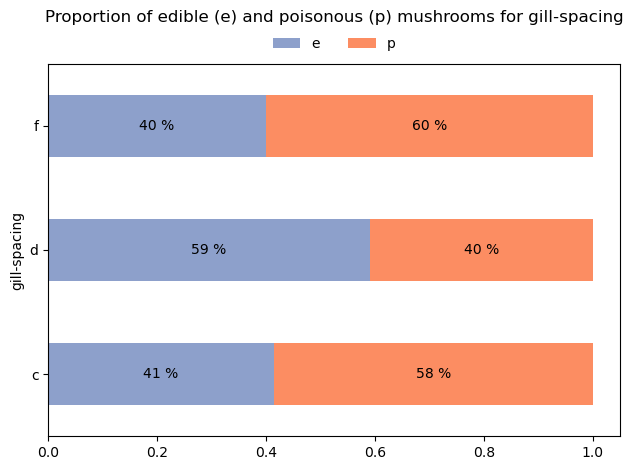

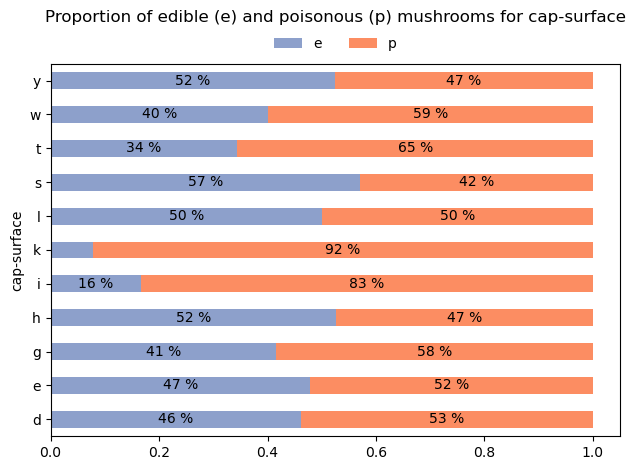

In [52]:
stacked_barh_100('stem-color', 'class', df)
stacked_barh_100('gill-attachment', 'class', df)
stacked_barh_100('gill-color', 'class', df)
stacked_barh_100('gill-spacing', 'class', df)
stacked_barh_100('cap-surface', 'class', df)

In [48]:
imps = pd.Series(cat_rf_grid_cv.best_estimator_.feature_importances_, index=cat_s_scaler.feature_names_in_).sort_values(ascending=False)

In [49]:
imps_dict = {}

for i in imps.index:
    imps_dict[i.split('_')[0]] = []

for i in imps.index:
    imps_dict[i.split('_')[0]].append(imps[i])

In [50]:
imps_dict_avgs = {}
for k,v_list in imps_dict.items():
    imps_dict_avgs[k] = np.average(v_list)
print(pd.Series(imps_dict_avgs).sort_values(ascending=False))
top_5_general = pd.Series(imps_dict_avgs).sort_values(ascending=False)[:5].index

does-bruise-or-bleed    0.021513
gill-spacing            0.020090
gill-attachment         0.017948
cap-surface             0.014637
cap-shape               0.014000
has-ring                0.012785
gill-color              0.009640
cap-color               0.008370
stem-color              0.007302
ring-type               0.006481
season                  0.005624
habitat                 0.005243
dtype: float64


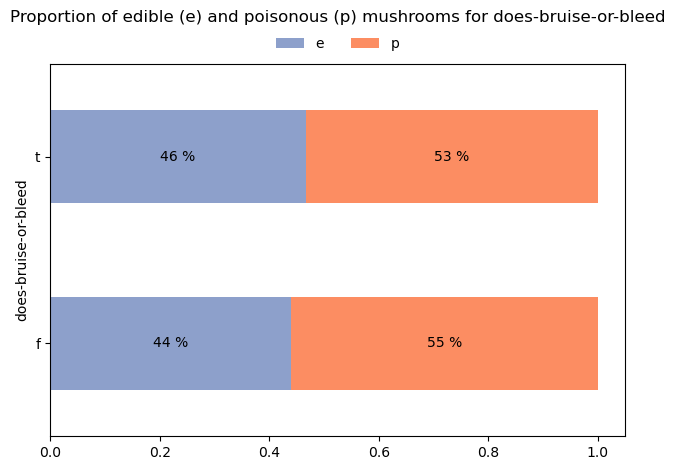

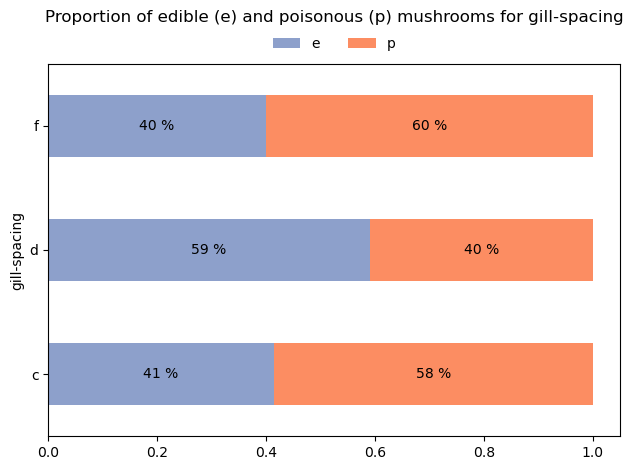

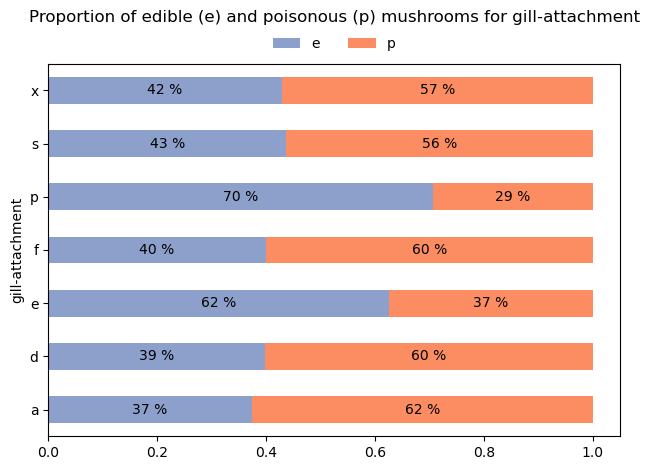

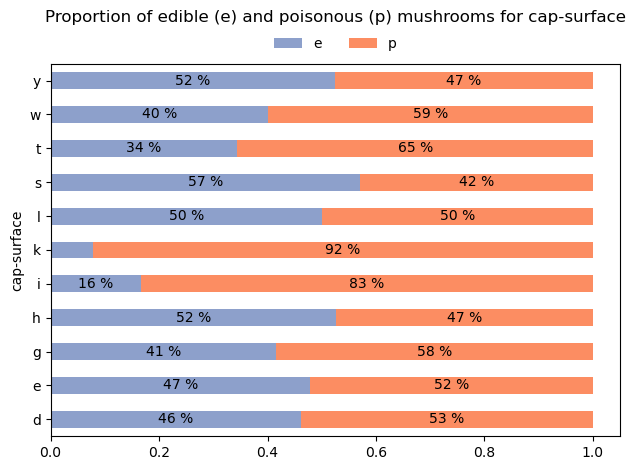

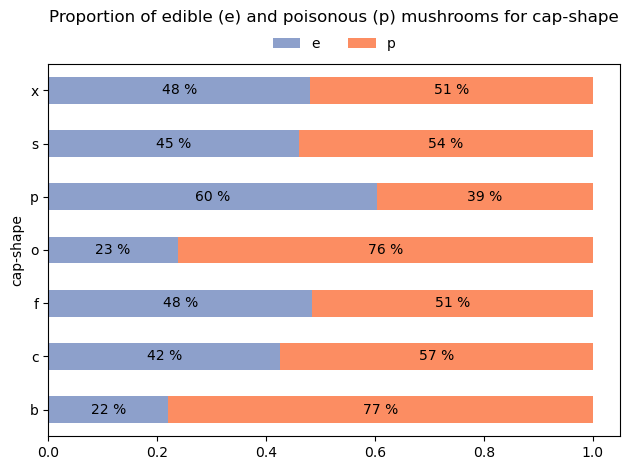

In [51]:
for feature in top_5_general:
    stacked_barh_100(feature, 'class', df)

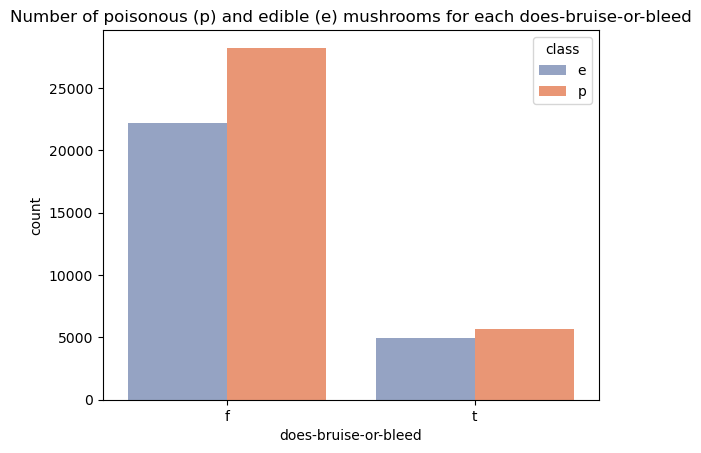

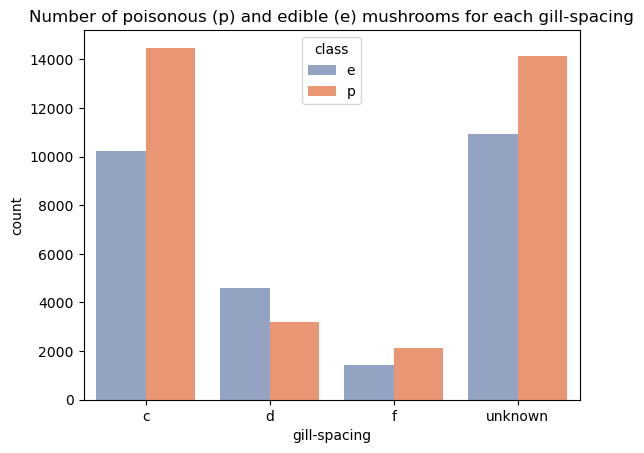

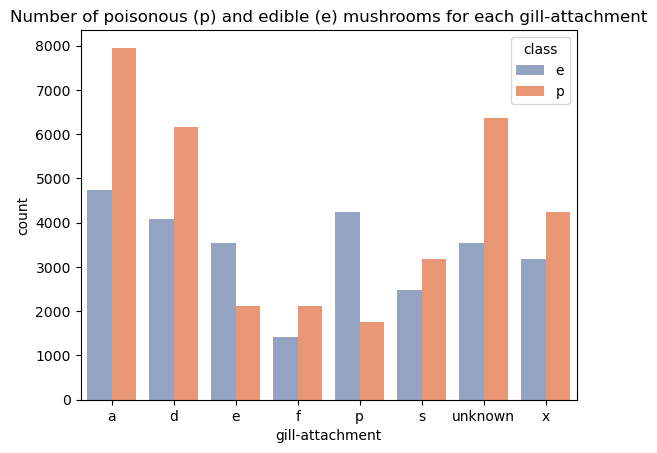

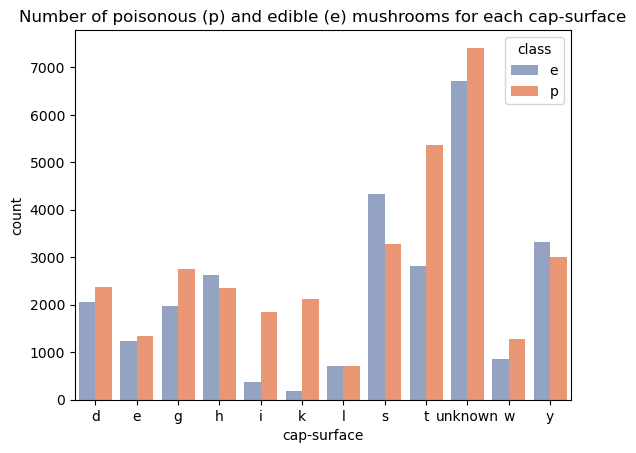

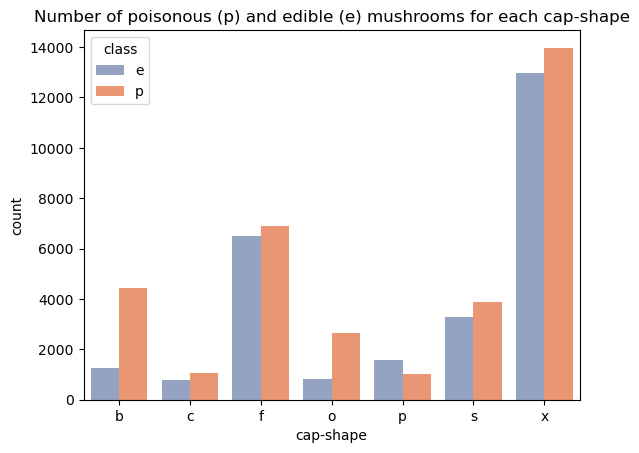

In [55]:
for c in top_5_general:
    sns.set_palette(['#8da0cb', '#fc8d62'])
    g = sns.countplot(data=full_df, x=c, hue='class')
    g.set_title('Number of poisonous (p) and edible (e) mushrooms for each {}'.format(c))
    plt.show()